In [1]:
from pathlib import Path
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import CIFAR10
import torchvision.transforms.v2 as transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import skimage.feature as feature
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
DATASET_PATH = Path().absolute().resolve() / "datasets"
%matplotlib inline
%config InlineBackend.figure_format='retina'
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

#### 1. Подготовка данных
* Выберите набор данных MNIST для классификации рукописных цифр. Или CIFAR-10 для классификации объектов в цветных изображениях.
* Разделите данные на обучающую (80%) и тестовую(20%) выборки.

В качестве набора данных для обучения возьмем CIFAR10.

Загрузим набор данных, определим базовую предобработку для обучения и разобьем на тренировочный, тестовый фолд.

Для разбиения на тренировочный и ntcnjdsq фолд будем использовать тренировочный фолд исходного набора данных в пропорции 80/20

In [2]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
inv_transform = transforms.Compose([
    transforms.Normalize(mean=(0., 0., 0.), std=(1/0.5, 1/0.5, 1/0.5)),
    transforms.Normalize(mean=(-0.5, -0.5, -0.5), std=(1., 1., 1.))
])

In [3]:
base_dataset = CIFAR10(DATASET_PATH, train=True, download=True)
train_dataset, test_dataset = random_split(base_dataset, [int(len(base_dataset) * 0.8), int(len(base_dataset) * 0.2)])

#### 2. Классификация с использованием kNN или SVM:
* Реализуйте классификатор k-ближайших соседей (kNN) или метод опорных векторов (SVM).
* Обучите модель на обучающей выборке. 
* Предскажите классы на тестовой выборке. Вычислите метрики качества: точность, полнота, F1-score.
* Постройте матрицу ошибок (confusion matrix).

Реализуем извлечение структурных признаков из изображений, которые будем использовать для предсказаний классификатора, в качестве таких признаков будем использовать

1. Гистограмма градиентов
1. Local Binary Pattern
1. Гистограммы интенсивности

In [4]:
def feature_extractor(img):
    img = np.array(img)
    gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    #hog features
    cell_size = (8, 8)
    block_size = (2, 2)
    n_bins = 9
    hog_features = feature.hog(
        gray_img,
        orientations=n_bins,
        pixels_per_cell=cell_size,
        cells_per_block=block_size,
    )

    #lbp
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(gray_img, n_points, radius, method='uniform')
    lbp_his, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), density=True)

    #intensity
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    color_hist = np.concatenate([
        cv.calcHist([hsv], [0], None, [16], [0, 180]).flatten(),
        cv.calcHist([hsv], [1], None, [16], [0, 256]).flatten(),
        cv.calcHist([hsv], [1], None, [16], [0, 256]).flatten(),
    ])

    features = np.concatenate([hog_features, lbp_his, color_hist])
    return features


def prepare_dataset(dataset):
    features = []
    labels = []
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        features.append(feature_extractor(img))
        labels.append(label)
    return np.vstack(features), np.asarray(labels)

In [5]:
X, y = prepare_dataset(train_dataset)
X.shape, y.shape

((40000, 398), (40000,))

In [6]:
X_test, y_test = prepare_dataset(test_dataset)
X_test.shape, y_test.shape

((10000, 398), (10000,))

В качестве модели будем использовать SVM, поскольку модель простая можем позовлить перебор параметров по сетке для отбора лучшей.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
clf = SVC(C=1., kernel='rbf')
clf.fit(X_scaled, y)

SVC()

In [8]:
X_test = scaler.transform(X_test)
preds = clf.predict(X_test)

**Валидация**

Теперь посмотрим на метрики классификации и **confusion matrix**

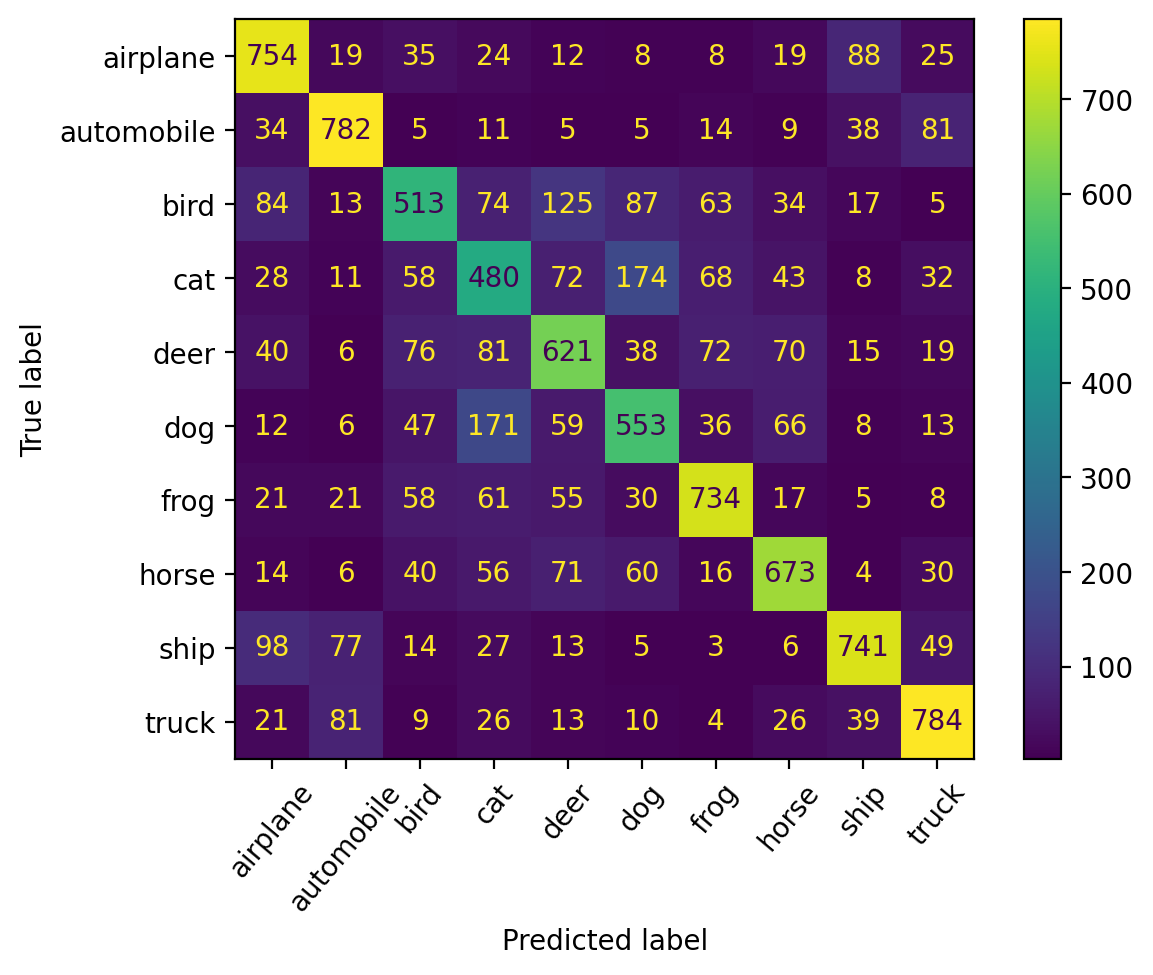

In [12]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=[key for key in base_dataset.class_to_idx.keys()])
disp.plot()
plt.xticks(rotation=50)
plt.show()

In [13]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       992
           1       0.77      0.79      0.78       984
           2       0.60      0.51      0.55      1015
           3       0.47      0.49      0.48       974
           4       0.59      0.60      0.60      1038
           5       0.57      0.57      0.57       971
           6       0.72      0.73      0.72      1010
           7       0.70      0.69      0.70       970
           8       0.77      0.72      0.74      1033
           9       0.75      0.77      0.76      1013

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



В целом качество получилось приемлимым для некоторых задач, особенно если учитывать скорость предсказания и интерпретируемость.

#### 3. Построение и обучение нейронной сети:
* Создайте многослойный перцептрон (MLP) с использованием Keras или PyTorch.
* Определите архитектуру сети (количество слоев, нейронов, функции активации).
* Обучите модель на тех же данных. Проанализируйте динамику обучения (графики потерь и точности).

In [4]:
32 * 32 * 3

3072

In [5]:
base_channels = 2048
new_channels = base_channels
layers = [nn.Sequential(nn.Flatten(start_dim=1), nn.Linear(3072, base_channels), nn.ReLU())]
for i in range(1, 3):
    if i % 2 == 0:
        new_channels = base_channels // 2
    layers.append(
        nn.Sequential(
            nn.Linear(base_channels, new_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
    )
    base_channels = new_channels
layers.append(nn.Linear(base_channels, len(base_dataset.class_to_idx)))
model = nn.Sequential(*layers).to(device)

In [6]:
lr = 1e-3
n_epoch = 70
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=2e-3)
base_dataset.transform = transform
test_dataset.transform = transform
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4, prefetch_factor=2)
test_loader = DataLoader(train_dataset, batch_size, shuffle=False, pin_memory=True, num_workers=4, prefetch_factor=2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch, eta_min=1e-6)

In [7]:
loss = torch.tensor(float('inf'))
for epoch in range(n_epoch):
    for imgs, labels in tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{n_epoch}] loss {loss.detach().item()}", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = model(imgs)
        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    scheduler.step()

Epoch [1/70] loss inf:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [2/70] loss 1.8424025774002075:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [3/70] loss 1.8247590065002441:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [4/70] loss 1.6926383972167969:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [5/70] loss 1.6747291088104248:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [6/70] loss 1.6009759902954102:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [7/70] loss 1.716223120689392:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [8/70] loss 1.6492185592651367:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [9/70] loss 1.5304702520370483:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [10/70] loss 1.5236189365386963:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [11/70] loss 1.6663821935653687:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [12/70] loss 1.6676161289215088:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [13/70] loss 1.7154178619384766:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [14/70] loss 1.5814509391784668:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [15/70] loss 1.5992666482925415:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [16/70] loss 1.4857194423675537:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [17/70] loss 1.5814354419708252:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [18/70] loss 1.5302090644836426:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [19/70] loss 1.6566781997680664:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [20/70] loss 1.5215706825256348:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [21/70] loss 1.5340914726257324:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [22/70] loss 1.536190152168274:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [23/70] loss 1.532525658607483:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [24/70] loss 1.4473289251327515:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [25/70] loss 1.549548864364624:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [26/70] loss 1.4448802471160889:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [27/70] loss 1.4055781364440918:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [28/70] loss 1.4352751970291138:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [29/70] loss 1.3103680610656738:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [30/70] loss 1.5039846897125244:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [31/70] loss 1.3190197944641113:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [32/70] loss 1.394240140914917:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [33/70] loss 1.3378312587738037:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [34/70] loss 1.3714302778244019:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [35/70] loss 1.2911131381988525:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [36/70] loss 1.399336814880371:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [37/70] loss 1.3273152112960815:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [38/70] loss 1.3036861419677734:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [39/70] loss 1.3258228302001953:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [40/70] loss 1.350154995918274:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [41/70] loss 1.328833818435669:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [42/70] loss 1.2802525758743286:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [43/70] loss 1.2307591438293457:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [44/70] loss 1.2818241119384766:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [45/70] loss 1.1469268798828125:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [46/70] loss 1.2862969636917114:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [47/70] loss 1.1980464458465576:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [48/70] loss 1.2498964071273804:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [49/70] loss 1.1559778451919556:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [50/70] loss 1.1127969026565552:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [51/70] loss 0.9480108022689819:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [52/70] loss 1.1671422719955444:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [53/70] loss 1.0412743091583252:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [54/70] loss 1.0663954019546509:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [55/70] loss 1.081005573272705:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [56/70] loss 0.8788946270942688:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [57/70] loss 1.0433027744293213:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [58/70] loss 0.9502216577529907:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [59/70] loss 0.8844457268714905:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [60/70] loss 0.8384971618652344:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [61/70] loss 0.8928788304328918:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [62/70] loss 0.9257493019104004:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [63/70] loss 0.8886972069740295:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [64/70] loss 0.8253360390663147:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [65/70] loss 0.7865822315216064:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [66/70] loss 0.8601984977722168:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [67/70] loss 0.866935670375824:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [68/70] loss 0.8159002661705017:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [69/70] loss 0.7600154876708984:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch [70/70] loss 0.8232739567756653:   0%|          | 0/156 [00:00<?, ?it/s]

**Валидация**

Теперь посмотрим на метрики классификации и **confusion matrix**

In [8]:
pred_labels = []
true_labels = []
model.eval()
for imgs, labels in tqdm(test_loader):
    imgs = imgs.to(device)
    labels = labels.to(device)
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    pred_labels.append(preds.argmax(dim=1).detach().cpu())
    true_labels.append(labels.detach().cpu())
pred_labels = torch.concat(pred_labels).numpy()
true_labels = torch.concat(true_labels).numpy()

  0%|          | 0/157 [00:00<?, ?it/s]

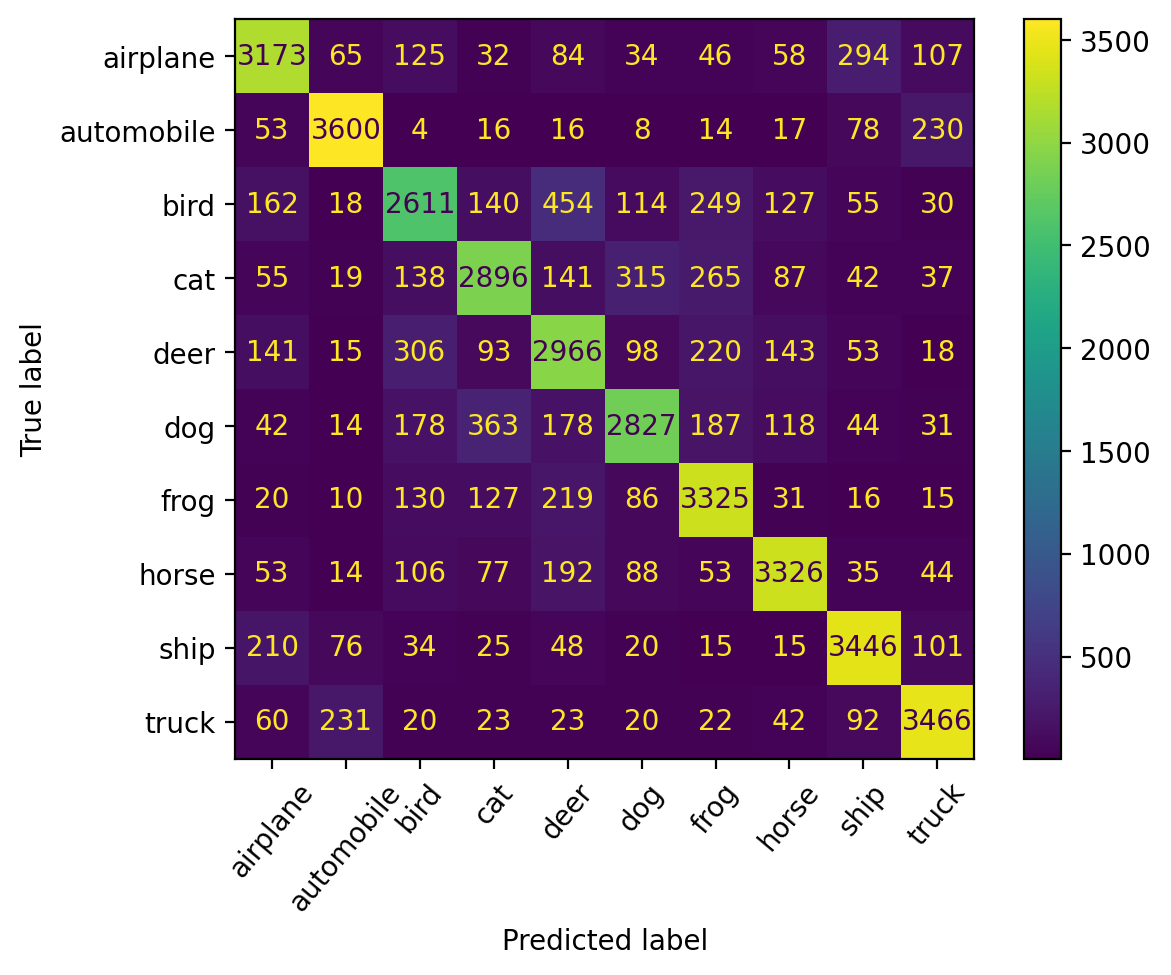

In [9]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=[key for key in base_dataset.class_to_idx.keys()])
disp.plot()
plt.xticks(rotation=50)
plt.show()

In [10]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      4018
           1       0.89      0.89      0.89      4036
           2       0.71      0.66      0.69      3960
           3       0.76      0.72      0.74      3995
           4       0.69      0.73      0.71      4053
           5       0.78      0.71      0.74      3982
           6       0.76      0.84      0.79      3979
           7       0.84      0.83      0.84      3988
           8       0.83      0.86      0.85      3990
           9       0.85      0.87      0.86      3999

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



Требует несколько больше ресурсов (быстрое обучение только на gpu) чем классический ml, но показывает намного лучшие результаты чем SVM.

#### 4. Сравнительный анализ моделей:
* Сравните результаты классического алгоритма (kNN/SVM) и нейронной сети.
* Обсудите преимущества и недостатки каждого.

Преимуществом классических подходов к классификации является простота внедрения моделей, скорость работы, а так же возможность точно интерпретировать результаты предсказаний.

В случае с нейросетевыми подходами плюсом является возможность апроксимировать (в теории) любую функцию, что позволяет неограниченно приблежать цель, однако минусом является более сложная настройка, необходимость в более тонкой настройки и отсутствии адекватной возможности интерпретации результатов, что в некоторых приложениях не позволяет использовать его из-за стохастичности (с точки зрения человека в виду отсутствия интерпретируемости).